In [1]:
TDDPM_DIR = "/home/liu00980/Documents/syn/tab-ddpm/"
SYNINF_DIR = "/home/liu00980/Documents/syn/tab-ddpm/syninf/"


import os
import pickle
import json


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import random
from copy import deepcopy

import sys
sys.path.insert(0, os.path.join(TDDPM_DIR, "utils/"))

from utils_syn import (
    concat_data,
    load_twin_null_models,
    load_pred_models,
    bias_correction,
    blackbox_test_stat,
    combine_Hommel,
)

In [2]:
dataset_name = "adult_female_3000"
null_features_list = ["age", "educationl-num", "hours-per-week"]

suffix = "_".join(null_features_list)

# dataset paths
dataset_dir = os.path.join(TDDPM_DIR, f"data/{dataset_name}")
dataset_dir_twin_1 = os.path.join(TDDPM_DIR, f"data/{dataset_name}_twin_1")
dataset_dir_twin_2 = os.path.join(TDDPM_DIR, f"data/{dataset_name}_twin_2")

# experiment paths
exp_dir_twin_1 = os.path.join(TDDPM_DIR, f"exp/{dataset_name}_twin_1/ddpm_cb_best")
exp_dir_twin_2 = os.path.join(TDDPM_DIR, f"exp/{dataset_name}_twin_2/ddpm_cb_best")

# meta info, names, pred & null model dictionaries
data_info_dict = json.load(open(os.path.join(dataset_dir_twin_1, "info.json"), "rb"))
names_dict = pickle.load(open(os.path.join(dataset_dir, "names_dict.pkl"), "rb"))
twin_null_model_dict = load_twin_null_models(dataset_name, null_features_list, root_dir=SYNINF_DIR)
pred_model_dict = load_pred_models(dataset_name, null_features_list, root_dir=SYNINF_DIR, **names_dict)

# inference result dictionarhy
result_dict_save_path = f"{SYNINF_DIR}/{dataset_name}/syngen_inf_result/result_dict_{suffix}.pkl"
result_dict = pickle.load(open(result_dict_save_path, "rb"))
print(result_dict["2.0"].keys())

dict_keys(['m', 'null_dist', 'type1_test_stat', 'learned_true_test_stat'])


In [3]:
# single fold p-value

alpha = 0.05
epsilon = 0.01

rho_list, type_I_error_list = [], []
for k, v_dict in result_dict.items():
    null_dist = np.array(v_dict["null_dist"])
    type1_test_stat = np.array(v_dict["type1_test_stat"])
    null_dist, type1_test_stat = bias_correction(null_dist, type1_test_stat, direction = "greater")
    
    p_values = []
    for t in type1_test_stat:
        p_value = np.mean(null_dist >= t)
        p_values.append(p_value)
    type_I_error = np.mean(np.array(p_values) <= alpha - epsilon)
    
    type_I_error_list.append(type_I_error)
    rho_list.append(float(k))

rho_list = np.array(rho_list)
type_I_error_list = np.array(type_I_error_list)


print(rho_list)
print(type_I_error_list)


[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.]
[0.042 0.054 0.039 0.046 0.054 0.037 0.046 0.048 0.05  0.049 0.043 0.05
 0.051 0.05  0.047 0.055 0.06  0.045 0.041 0.059]


In [4]:
# p-value combination, add bias correction


p_values_dict_1 = {}
for k, v_dict in result_dict.items():
    null_dist = np.array(v_dict["null_dist"])
    type1_test_stat = np.array(v_dict["type1_test_stat"])
    null_dist, type1_test_stat = bias_correction(null_dist, type1_test_stat, direction = "greater")

    p_values = []
    for t in type1_test_stat:
        p_value = np.mean(null_dist >= t)
        p_values.append(p_value)

    p_values_dict_1[k] = p_values


p_values_dict_2 = {}
for k, v_dict in result_dict.items():
    # switch the roles of null_dist and type1_test_stat
    null_dist = np.array(v_dict["type1_test_stat"])
    type1_test_stat = np.array(v_dict["null_dist"])
    null_dist, type1_test_stat = bias_correction(null_dist, type1_test_stat, direction = "greater")

    p_values = []
    for t in type1_test_stat:
        # p_value = 2 * min(np.mean(null_dist >= t), np.mean(null_dist <= t))
        p_value = np.mean(null_dist >= t)
        p_values.append(p_value)

    p_values_dict_2[k] = p_values


p_values_dict_combined = {}
for k in result_dict.keys():
    p_values_dict_combined[k] = [
        combine_Hommel([p1, p2])
        for p1, p2 in zip(p_values_dict_1[k], p_values_dict_2[k])
    ]


# type-I error control
alpha = 0.05
epsilon = 0.01

rho_list, type_I_error_list = [], []
for k in result_dict.keys():
    p_values = p_values_dict_combined[k]
    type_I_error = np.mean(np.array(p_values) <= alpha - epsilon)

    type_I_error_list.append(type_I_error)
    rho_list.append(float(k))


rho_list = np.array(rho_list)
type_I_error_list = np.array(type_I_error_list)

print(rho_list)
print(type_I_error_list)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.]
[0.031 0.033 0.037 0.036 0.033 0.039 0.043 0.042 0.04  0.039 0.049 0.046
 0.044 0.05  0.054 0.053 0.048 0.06  0.06  0.052]


Text(0.5, 1.0, 'Adult-Female: Type-I error curve')

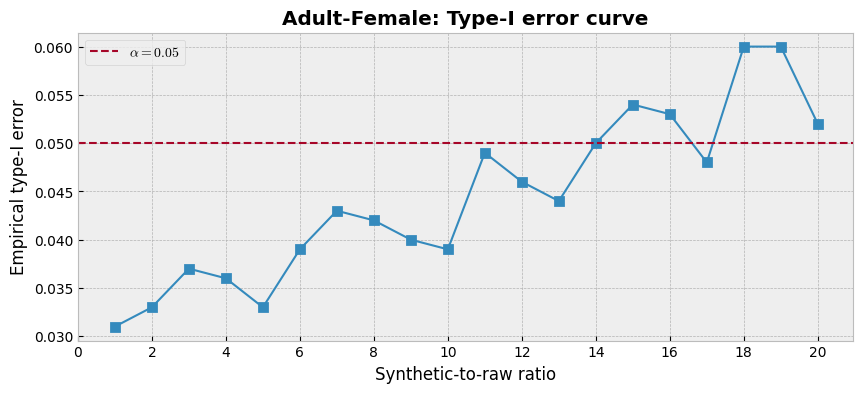

In [5]:
# SynTest: Type-I error curve as function of synthetic-to-raw ratio'

rho_list = np.array(list(result_dict.keys()), dtype=np.float32)


plt.style.use("bmh")

plt.figure(figsize=(10, 4))


plt.plot(
    rho_list,
    type_I_error_list,
    marker="s",
    mew=2,
    linestyle="-",
    markersize=6,
    linewidth=1.5,
)

plt.axhline(alpha, linestyle="--", color="C1", linewidth=1.5, label=r"$\alpha=0.05$")

plt.legend()

plt.xticks(ticks=np.arange(0, 21, 2))
plt.xlabel("Synthetic-to-raw ratio")


plt.ylabel("Empirical type-I error")

plt.title("Adult-Female: Type-I error curve", fontweight="bold")


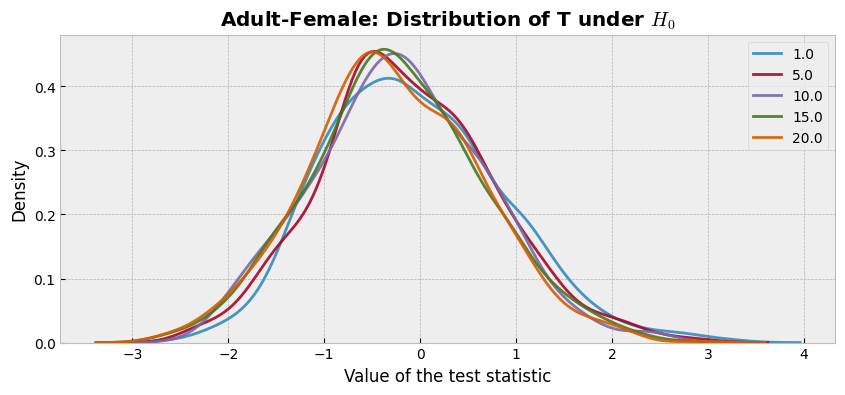

In [6]:
# distribution of the test statistics w.r.t. different ratios, under the NULL hypothesis, after bias correction

result_dict_corrected = {}
for k, v_dict in result_dict.items():
    null_dist = np.array(v_dict["null_dist"])
    type1_test_stat = np.array(v_dict["type1_test_stat"])
    null_dist, type1_test_stat = bias_correction(null_dist, type1_test_stat, direction = "greater")
    
    v_dict_temp = deepcopy(v_dict)
    v_dict_temp["null_dist"] = null_dist
    v_dict_temp["type1_test_stat"] = type1_test_stat
    result_dict_corrected[k] = v_dict_temp



plt.figure(figsize=(10, 4))

for rho in np.array([1.0, 5, 10, 15, 20]):
    temp_data = result_dict_corrected[str(rho)]["null_dist"]
    sns.kdeplot(temp_data, fill=False, label=str(rho), alpha = 0.9, common_grid=True, linewidth=2)

plt.xlabel("Value of the test statistic")
plt.title(r"Adult-Female: Distribution of T under $H_0$", fontweight="bold")
plt.legend()

In [7]:
# power stuff
inf_df = concat_data(dataset_dir_twin_1, split="train", **names_dict)
test_stat_inf = blackbox_test_stat(
    inf_df,
    pred_model_dict["full"],
    pred_model_dict["partial"],
    **names_dict,
    null_feature_names=null_features_list,
)
print(test_stat_inf)

2.964882353525296


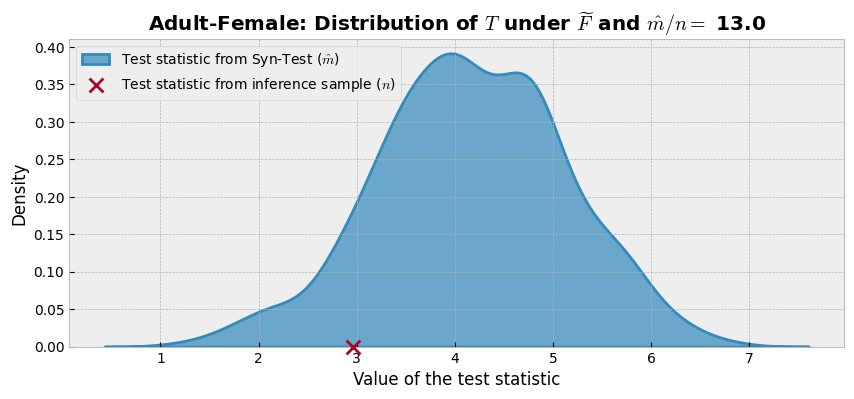

In [8]:

rho = "13.0"
test_stat_list = np.array(result_dict[rho]["learned_true_test_stat"])


plt.figure(figsize=(10, 4))
ax = sns.kdeplot(test_stat_list, fill=True, alpha = 0.7, common_grid=True, linewidth=2, label=r"Test statistic from Syn-Test ($\hat m$)")

y_min, y_max = ax.get_ylim()

ax.scatter(x = test_stat_inf, y = y_min, marker = 'x', zorder = 10, clip_on = False, s=100, label=r"Test statistic from inference sample ($n$)")

ax.set_ylim(y_min, y_max)

plt.xlabel("Value of the test statistic")
plt.title(rf"Adult-Female: Distribution of $T$ under $\widetilde F$ and $\hat m/n =$ {rho}", fontweight="bold")
plt.legend(loc="upper left")